<a href="https://colab.research.google.com/github/fatemafaria142/Comparative-Analysis-of-Pretrained-BERT-models-for-Natural-Language-Inference-on-Bangla-XNLI-Dataset/blob/main/Bangla_XNLI_using_Bangla_bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,log_loss,jaccard_score,roc_auc_score,classification_report,confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [21]:
!pip install datasets

### **Dataset link:** https://huggingface.co/datasets/csebuetnlp/xnli_bn

In [22]:
from datasets import load_dataset

dataset = load_dataset("csebuetnlp/xnli_bn")

In [23]:
# Access train, test, and validation splits
train_data = dataset['train']
test_data = dataset['test']
validation_data = dataset['validation']

# Optional: You can also print the number of examples in each split
print(f"Number of examples in train set: {len(train_data)}")
print(f"Number of examples in test set: {len(test_data)}")
print(f"Number of examples in validation set: {len(validation_data)}")

Number of examples in train set: 381449
Number of examples in test set: 4895
Number of examples in validation set: 2419


In [24]:
# Access train data
train_data = dataset['train']

# Create a DataFrame from the dataset
df_train = pd.DataFrame(train_data[:15000])  # Taking the first 15,000 rows

# Map numeric labels to textual representations
label_map = {
    0: 'Contradiction',
    1: 'Entailment',
    2: 'Neutral'
}

df_train['label'] = df_train['label'].map(label_map)

# Display the modified DataFrame with the new column
df_train.head()


,sentence1,sentence2,label
0,ধারণাগতভাবে ক্রীম স্কিমিং এর দুটি মৌলিক মাত্রা...,পণ্য এবং ভূগোল হচ্ছে ক্রিমের স্কিমিং কাজ।,Neutral
1,আপনি জানেন এই মৌসুমে আর আমার মনে হয় আপনার পর্...,মানুষ যদি স্মরণ করতে পারে তাহলে আপনি নীচের স্ত...,Entailment
2,আমাদের মধ্যে একজন আপনার নির্দেশগুলো পুঙ্খানুপু...,আমার দলের একজন সদস্য আপনার আদেশ পালন করবেন অত্...,Entailment
3,আপনি কিভাবে জানলেন? এই সব তাদের তথ্য আবার.,এই তথ্যটি তাদের।,Entailment
4,হ্যাঁ আমি তোমাকে বলি যদি তুমি কিছু টেনিসের জুত...,টেনিসের জুতার দাম অনেক।,Neutral


In [25]:
# Access test data
test_data = dataset['test']

# Create a DataFrame from the dataset
df_test = pd.DataFrame(test_data)

# Map numeric labels to textual representations
label_map = {
    0: 'Contradiction',
    1: 'Entailment',
    2: 'Neutral'
}

df_test['label'] = df_test['label'].map(label_map)

# Display the modified DataFrame with the new column
df_test.head()


,sentence1,sentence2,label
0,"আসলে, আমি এমনকি এই বিষয়ে চিন্তাও করিনি, কিন্ত...",আমি তার সাথে আবার কথা বলিনি।,Contradiction
1,"আসলে, আমি এমনকি এই বিষয়ে চিন্তাও করিনি, কিন্ত...","আমি এতই ভেঙে পড়েছিলাম যে, আমি আবারও তার সঙ্গে...",Entailment
2,"আসলে, আমি এমনকি এই বিষয়ে চিন্তাও করিনি, কিন্ত...",আমাদের খুব ভালো কথা হয়েছিল।,Neutral
3,"আর আমি ভেবেছিলাম এটা একটা বিশেষ সুযোগ, আর এখনো...","আমি জানতাম না যে, সেই দিন আমিই একমাত্র ব্যক্তি...",Neutral
4,"আর আমি ভেবেছিলাম এটা একটা বিশেষ সুযোগ, আর এখনো...",আমার মনে হয়েছিল যে এএফএফসি বিমান বাহিনীর ক্যা...,Entailment


In [26]:
# Access validation data
validation_data = dataset['validation']

# Create a DataFrame from the dataset
df_validation = pd.DataFrame(validation_data)

# Map numeric labels to textual representations
label_map = {
    0: 'Contradiction',
    1: 'Entailment',
    2: 'Neutral'
}

df_validation['label'] = df_validation['label'].map(label_map)

# Display the modified DataFrame with the new column
df_validation.head()


,sentence1,sentence2,label
0,"আর সে বললো, মা, আমি বাড়ি।",স্কুলের বাস তাকে নামিয়ে দেওয়ার সঙ্গে সঙ্গে ত...,Neutral
1,"আর সে বললো, মা, আমি বাড়ি।",সে কোন কথা বলেনি.,Contradiction
2,"আর সে বললো, মা, আমি বাড়ি।",সে তার মাকে বলেছিল যে সে বাড়ি ফিরে এসেছে।,Entailment
3,"আমি জানতাম না আমি কি জন্য যাচ্ছি বা কিছু, তাই ...",আমি কখনো ওয়াশিংটনে যাইনি তাই যখন আমাকে সেখানে...,Neutral
4,"আমি জানতাম না আমি কি জন্য যাচ্ছি বা কিছু, তাই ...","আমি ঠিক জানতাম যে, ওয়াশিংটনের দিকে যাত্রা করা...",Contradiction


# **Visualization of Label Distribution in Train dataset**
* Contradiction - 0
* Entailment - 1
* Neutral - 2

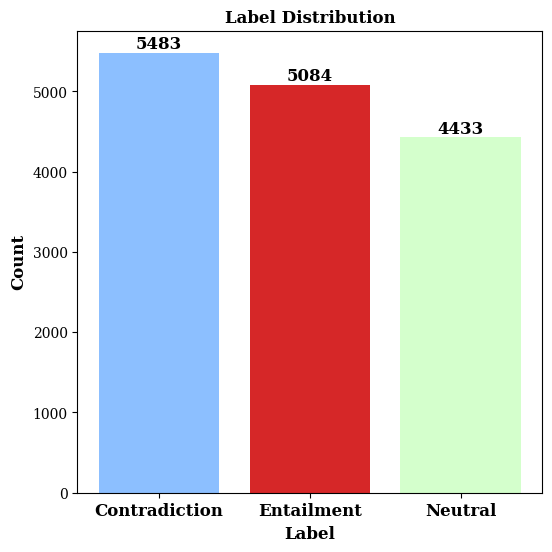

In [27]:
label_counts = df_train['label'].value_counts()

# Define custom colors for the bars ('e', 'c', and 'n')
custom_colors = ['#8cbfff', '#d62728','#d4ffcc']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Label Distribution', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Label Distribution in Test dataset**
* Contradiction - 0
* Entailment - 1
* Neutral - 2

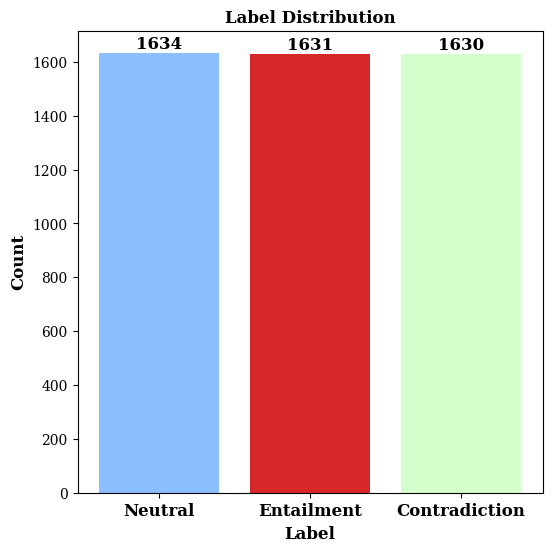

In [28]:
label_counts = df_test['label'].value_counts()

# Define custom colors for the bars ('e', 'c', and 'n')
custom_colors = ['#8cbfff', '#d62728','#d4ffcc']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Label Distribution', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Label Distribution in Validation dataset**
* Contradiction - 0
* Entailment - 1
* Neutral - 2

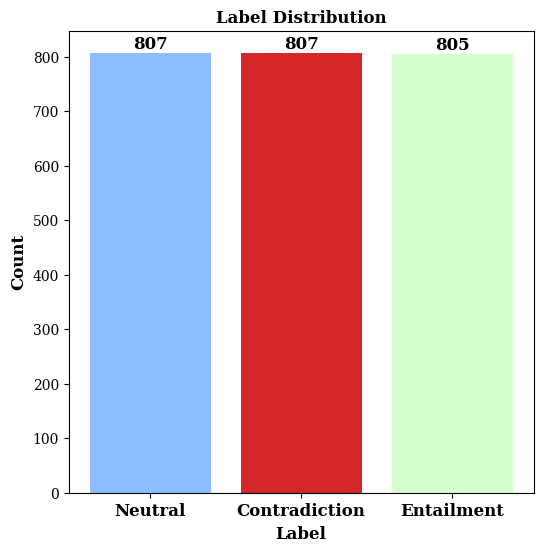

In [29]:
label_counts = df_validation['label'].value_counts()

# Define custom colors for the bars ('e', 'c', and 'n')
custom_colors = ['#8cbfff', '#d62728','#d4ffcc']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Label Distribution', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Premise Length Distribution in Train Dataset**
## **sentence1 length checking**

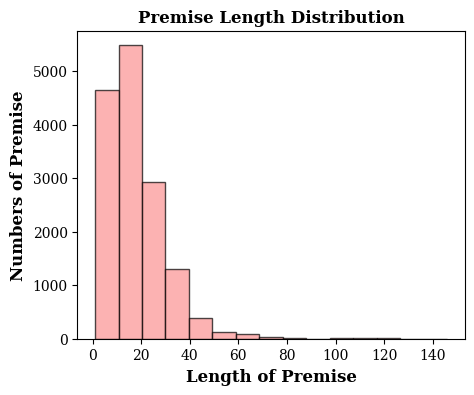

In [30]:
# Visualize premise length distribution
premise_lengths = df_train['sentence1'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
custom_colors = ['#fc9292']
plt.figure(figsize=(5, 4))
plt.hist(premise_lengths, bins=15, color=custom_colors,edgecolor='black' ,alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Premise Length Distribution',fontdict=font)
plt.xlabel('Length of Premise',fontdict=font)
plt.ylabel('Numbers of Premise',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
#plt.grid(True)
plt.show()

# **Visualization of Premise Length Distribution in Test Dataset**
## **sentence1 length checking**

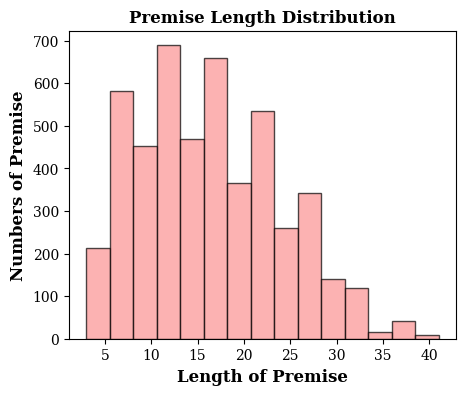

In [31]:
# Visualize premise length distribution
premise_lengths = df_test['sentence1'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
custom_colors = ['#fc9292']
plt.figure(figsize=(5, 4))
plt.hist(premise_lengths, bins=15, color=custom_colors,edgecolor='black' ,alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Premise Length Distribution',fontdict=font)
plt.xlabel('Length of Premise',fontdict=font)
plt.ylabel('Numbers of Premise',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
#plt.grid(True)
plt.show()

# **Visualization of Premise Length Distribution in Validation Dataset**
## **sentence1 length checking**

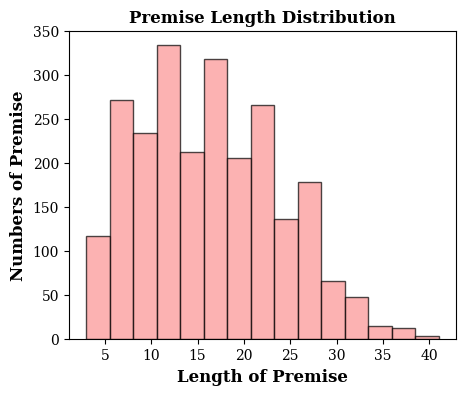

In [32]:
# Visualize premise length distribution
premise_lengths = df_validation['sentence1'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
custom_colors = ['#fc9292']
plt.figure(figsize=(5, 4))
plt.hist(premise_lengths, bins=15, color=custom_colors,edgecolor='black' ,alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Premise Length Distribution',fontdict=font)
plt.xlabel('Length of Premise',fontdict=font)
plt.ylabel('Numbers of Premise',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
#plt.grid(True)
plt.show()

# **Dataset Length**

In [33]:
print(f"Train Dataset Length: {len(df_train)}")
print(f"Test Dataset Length: {len(df_test)}")
print(f"Validation Dataset Length: {len(df_validation)}")

Train Dataset Length: 15000
Test Dataset Length: 4895
Validation Dataset Length: 2419


# **Null value checking in Train dataset**

In [34]:
# Check for null values in 'premise', 'hypothesis' and	'label' columns
null_premise = df_train['sentence1'].isnull().sum()
null_hypothesis = df_train['sentence2'].isnull().sum()
null_label = df_train['label'].isnull().sum()


print(f"Null values in 'sentence1': {null_premise}")
print(f"Null values in 'sentence2': {null_hypothesis}")
print(f"Null values in 'label': {null_label}")


Null values in 'sentence1': 0
Null values in 'sentence2': 0
Null values in 'label': 0


# **Null value checking in Test dataset**

In [35]:
# Check for null values in 'premise', 'hypothesis' and	'label' columns
null_premise = df_test['sentence1'].isnull().sum()
null_hypothesis = df_test['sentence2'].isnull().sum()
null_label = df_test['label'].isnull().sum()


print(f"Null values in 'sentence1': {null_premise}")
print(f"Null values in 'sentence2': {null_hypothesis}")
print(f"Null values in 'label': {null_label}")


Null values in 'sentence1': 0
Null values in 'sentence2': 0
Null values in 'label': 0


# **Null value checking in Validation dataset**

In [36]:
# Check for null values in 'premise', 'hypothesis' and	'label' columns
null_premise = df_validation['sentence1'].isnull().sum()
null_hypothesis = df_validation['sentence2'].isnull().sum()
null_label = df_validation['label'].isnull().sum()


print(f"Null values in 'sentence1': {null_premise}")
print(f"Null values in 'sentence2': {null_hypothesis}")
print(f"Null values in 'label': {null_label}")


Null values in 'sentence1': 0
Null values in 'sentence2': 0
Null values in 'label': 0


# **Bangla-bert-base model and its tokenizer**

In [38]:
# Model loading
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW

num_classes = 3  #number of classes in our dataset

model_name = "sagorsarker/bangla-bert-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [39]:
# Place model on the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [40]:
from torch.utils.data import Dataset, DataLoader
import torch

# **Custom Dataset Class**

In [41]:
class NaturalLanguageInferenceDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = {'Contradiction': 0, 'Entailment': 1, 'Neutral': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        premise = self.data.iloc[idx]['sentence1']
        hypothesis = self.data.iloc[idx]['sentence2']
        label = self.data.iloc[idx]['label']

        # Map label to integer
        label_id = self.label_map[label]

        # Tokenize premise and hypothesis separately
        encoded_dict_premise = self.tokenizer.encode_plus(
            premise,
            add_special_tokens=True,
            max_length=self.max_length // 2,  # Allocate half of the max_length to each
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        encoded_dict_hypothesis = self.tokenizer.encode_plus(
            hypothesis,
            add_special_tokens=True,
            max_length=self.max_length // 2,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        # Concatenate input_ids and attention_masks
        input_ids = torch.cat((encoded_dict_premise['input_ids'], encoded_dict_hypothesis['input_ids']), dim=1)
        attention_mask = torch.cat((encoded_dict_premise['attention_mask'], encoded_dict_hypothesis['attention_mask']), dim=1)

        return {
            'input_ids': input_ids.squeeze(),
            'attention_mask': attention_mask.squeeze(),
            'label': torch.tensor(label_id, dtype=torch.long)  # Use mapped label_id
        }


# **Custom dataset and dataloader**

In [42]:
# Define custom datasets
train_dataset = NaturalLanguageInferenceDataset(df_train, tokenizer)
val_dataset = NaturalLanguageInferenceDataset(df_validation, tokenizer)
test_dataset = NaturalLanguageInferenceDataset(df_test, tokenizer)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# **Train Dataset Encoding Printing**

In [43]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([  101,  3335,  1012,  8566,  2756, 10706, 33553,  2446, 21327,  5222,
         6509,  2040,  2282, 28184,  1026,  2050,  7462,  2094,  2395, 86336,
         1014,  2076, 25492, 18655,  8705, 50569, 15281,  6943, 26971,  5602,
         1011,  7231,  7428,  4804,  8261, 63614,  6459, 13477, 20379,  2429,
        96152,  6187,  2046, 14973,  3867,  9294,  2446, 21327,  5222,  6509,
         2040,  2051, 38238, 63129,  2046,  2282,  3020,  9294,  1014,   102,
            0,     0,     0,     0,   101, 63614,  6459, 13477, 20379,  2429,
        96152,  2046, 50569, 15281,  4531, 15537, 32615, 27900,  2200,  7231,
         7428,  4804, 40017,  8844,  2046, 14973,  3867,  9294,  2446, 21327,
         5222,  6509,  2040,  2051, 38238, 63129,  2046,  2282,  3020,  9294,
         1014,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

# **Test Dataset Encoding Printing**

In [44]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([  101,  2746,  1011,  2169,  2752,  2045,  8136,  8844, 45484, 23933,
         8756,  1011, 77801,  2169,  2592,  6222, 33668,  2094, 71923,  2094,
        14523,  2060,  1011,  2158,  2076, 56469,  3283,  2169,  2239,  2056,
        47174,  9417,  2085,  2362, 14033,  6625,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   101,  2169,  2056,  2179,  2239,  2085,
        26217,  1014,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

# **Validation Dataset Encoding Printing**

In [45]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([  101,  2070,  2118,  6635,  2395,  1011,  2411,  1011,  2169,  2069,
         6231,  1014,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   101, 10224,  2773,  2271, 37071,  8844,
        21380, 14979, 47174,  9417, 47174,  9417,  2049,  2056,  6892, 16359,
         5803,  2263,  1014,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

# **Train Dataset Decoding Printing**

In [46]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: তিনি দকষিণের ইতিহাস এবং চিঠি, জনপরিয সংসকতি এবং রনধনপরণালীর উপর এক দকষ এবং পরাণবনত উপলবধি পরদরশন করেন । তিনি দকষিণের ইতিহাস ও সংসকতি নিযে পরচর গবেষণা করেছেন ।
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: [unused1]


# **Test Dataset Decoding Printing**

In [47]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: আসলে, আমি এমনকি এই বিষযে চিনতাও করিনি, কিনত আমি এত হতাশ হযে পডেছিলাম যে, শেষ পরযনত আমি আবার তার সঙগে কথা বলতে শর করেছিলাম আমি তার সাথে আবার কথা বলিনি ।
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: 


# **Validation Dataset Decoding Printing**

In [48]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: আর সে বললো, মা, আমি বাডি । সকলের বাস তাকে নামিযে দেওযার সঙগে সঙগে তিনি তার মাকে ফোন করেছিলেন ।
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: [unused1]


# **Optimizer and Loss Function**

In [49]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# **Training the model**

In [50]:
# Training loop
num_epochs = 5
gradient_accumulation_steps = 4  # Accumulate gradients over 4 steps

for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    # Wrap train_loader with tqdm for progress bar
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average training loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_preds = []
    val_labels = []

    # Wrap val_loader with tqdm for progress bar
    for batch in tqdm(val_loader, desc=f'Validation', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        _, predicted = torch.max(logits, 1)

        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_accuracy:.4f}')

    # Calculate and print epoch training time
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")

Epoch 1/5 - Average training loss: 0.9992


Epoch 1/5 - Validation Accuracy: 0.5577
Epoch 1 completed in 5m 31s


Epoch 2/5 - Average training loss: 0.8516


Epoch 2/5 - Validation Accuracy: 0.5870
Epoch 2 completed in 5m 31s


Epoch 3/5 - Average training loss: 0.6834


Epoch 3/5 - Validation Accuracy: 0.5825
Epoch 3 completed in 5m 32s


Epoch 4/5 - Average training loss: 0.4807


Epoch 4/5 - Validation Accuracy: 0.5618
Epoch 4 completed in 5m 32s


Epoch 5/5 - Average training loss: 0.2876


Epoch 5/5 - Validation Accuracy: 0.5560
Epoch 5 completed in 5m 32s


# **Testing the model**

In [51]:
test_preds = []
test_labels = []
test_probs = []  # Store predicted probabilities

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Assuming our model directly outputs logits
        probabilities = torch.softmax(outputs.logits, dim=1)  # Softmax to get probabilities
        _, predicted = torch.max(outputs.logits, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probabilities.cpu().numpy())  # Append predicted probabilities

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='macro')
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')
test_jaccard_score = jaccard_score(test_labels, test_preds, average='macro')
test_log_loss = log_loss(test_labels, test_probs)


Testing: 100%|██████████| 490/490 [00:38<00:00, 12.71it/s]


In [52]:
print(test_preds)
print(test_labels)

[0, 1, 2, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 2, 0, 1, 2, 1, 0, 2, 0, 1, 1, 2, 1, 1, 2, 1, 0, 1, 0, 1, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 2, 2, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 0, 2, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 2, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 2, 1, 1, 0, 2, 0, 1, 1, 2, 0, 2, 0, 1, 2, 1, 0, 1, 1, 1, 0, 2, 0, 0, 2, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 0, 1, 0, 0, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 1, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

# **Evaluation Metrics**

In [53]:
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Jaccard Score: {test_jaccard_score}')
print(f'Test Log Loss: {test_log_loss}')

Test Accuracy: 0.5697650663942799
Test Precision: 0.5687095850630655
Test Recall: 0.5698621919519941
Test F1 Score: 0.5654666806485756
Test Jaccard Score: 0.396150013548982
Test Log Loss: 1.518229997816259


* For a multiclass problem, sensitivity and specificity are typically calculated using a one-vs-all (or one-vs-rest) approach. This means treating each class as the positive class once while aggregating the others as the negative class.

In [54]:
from sklearn.metrics import confusion_matrix

def sensitivity_score_multiclass(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    true_positives = cm[class_label, class_label]
    actual_positives = sum(cm[class_label, :])
    return true_positives / actual_positives if actual_positives != 0 else 0

num_classes = 3  # We have 3 classes (adjust according to your dataset)

sensitivity_scores = []
for class_label in range(num_classes):
    sensitivity = sensitivity_score_multiclass(test_labels, test_preds, class_label)
    sensitivity_scores.append(sensitivity)

print("Sensitivity (Recall) for each class:", sensitivity_scores)

Sensitivity (Recall) for each class: [0.6355828220858896, 0.6407112201103617, 0.43329253365973075]


In [55]:
def specificity_score_multiclass(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    true_negatives = sum(sum(cm)) - sum(cm[class_label, :]) - sum(cm[:, class_label]) + cm[class_label, class_label]
    actual_negatives = sum(sum(cm)) - sum(cm[class_label, :])
    return true_negatives / actual_negatives if actual_negatives != 0 else 0
specificity_scores = []
for class_label in range(num_classes):
    specificity = specificity_score_multiclass(test_labels, test_preds, class_label)
    specificity_scores.append(specificity)

print("Specificity for each class:", specificity_scores)


Specificity for each class: [0.7650842266462481, 0.7607230392156863, 0.828886844526219]


In [56]:
from sklearn.preprocessing import LabelBinarizer
# Convert labels to one-hot encoded format
label_binarizer = LabelBinarizer()
test_labels_one_hot = label_binarizer.fit_transform(test_labels)

# Reshape the one-hot encoded labels
num_classes = len(label_binarizer.classes_)
test_labels_one_hot = test_labels_one_hot.reshape(-1, num_classes)

# Creating a 2D array for test_preds
num_samples = len(test_preds)
num_classes = len(label_binarizer.classes_)
formatted_preds = [[0] * num_classes for _ in range(num_samples)]
for i, pred in enumerate(test_preds):
    formatted_preds[i][pred] = 1

# Calculate ROC AUC score for multiclass classification
test_roc_auc_score = roc_auc_score(test_labels_one_hot, formatted_preds, average='macro', multi_class='ovo')
print("Test ROC AUC Score:", test_roc_auc_score)

Test ROC AUC Score: 0.6773801143740226


In [57]:
# Mapping numeric labels to category names
label_map = {0: 'Entailment', 1: 'Contradiction', 2: 'Neutral'}

# Convert numeric predictions to label names
predicted_labels = [label_map[pred] for pred in test_preds]
true_labels = [label_map[label] for label in test_labels]

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

Contradiction       0.57      0.64      0.60      1631
   Entailment       0.57      0.64      0.60      1630
      Neutral       0.56      0.43      0.49      1634

     accuracy                           0.57      4895
    macro avg       0.57      0.57      0.57      4895
 weighted avg       0.57      0.57      0.57      4895



# **Confusion Matrix for MultiNLI Dataset**

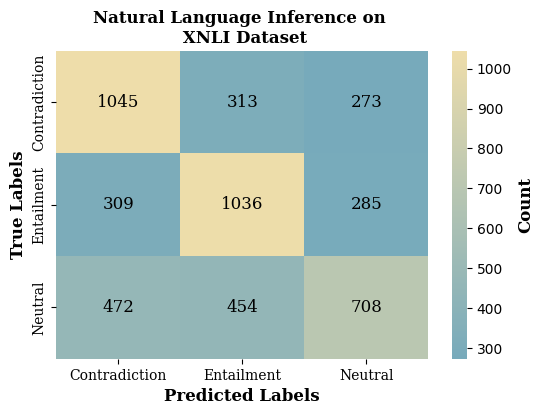

In [58]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.color_palette("blend:#7AB,#EDA", as_cmap=True) # Modify the number based on number of classes in the dataset
#sns.color_palette("Spectral", as_cmap=True)

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=['Contradiction', 'Entailment', 'Neutral'], yticklabels=['Contradiction', 'Entailment', 'Neutral'],annot_kws={"family": "Serif", 'size': 12, 'color':'black'})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Natural Language Inference on \n XNLI Dataset', fontdict=font)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=10)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)

plt.show()


# **Save results to a csv file**

In [59]:
# Combine the lists into a DataFrame
data = {'Sentence1': df_test['sentence1'],
        'Sentence2': df_test['sentence2'],
        'True_Labels': df_test['label'],
        'Predicted_Labels': test_preds}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('predicted_results.csv', index=False)


# **Save the model and its tokenizer**

In [60]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Model.pt')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Tokenizer.json')

('/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Tokenizer.json/tokenizer_config.json',
 '/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Tokenizer.json/special_tokens_map.json',
 '/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Tokenizer.json/vocab.txt',
 '/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Tokenizer.json/added_tokens.json',
 '/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Tokenizer.json/tokenizer.json')

# **Load the model and its tokenizer**

In [61]:
# load the model
model.from_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Model.pt')

# load the tokenizer
tokenizer.from_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Tokenizer.json')


BertTokenizerFast(name_or_path='/content/drive/MyDrive/Natural_Language_Inference/NLI_Bangla-bert-base/NLI_Bangla-bert-base_Tokenizer.json', vocab_size=101975, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}